# Building and Testing Corrective RAG

[Corrective-RAG (CRAG)](https://arxiv.org/abs/2401.15884) is a strategy for RAG that incorporates self-reflection / self-grading on retrieved documents.

Here, we will do 5 things -- 

* Show how to implement this as a ReAct agent
* Show how to implement this as a custom LangGraph agent
* Show how to build an evaluation set of question-answer pairs
* Show how to evaluate end-to-end performance of our agents
* Show how to evaluate tool use by our agents

We will reference ideas from [these slides](https://docs.google.com/presentation/d/1QWkXi4DYjfw94eHcy9RMLqpQdJtS2C_kx_u7wAUvlZE/edit?usp=sharing).

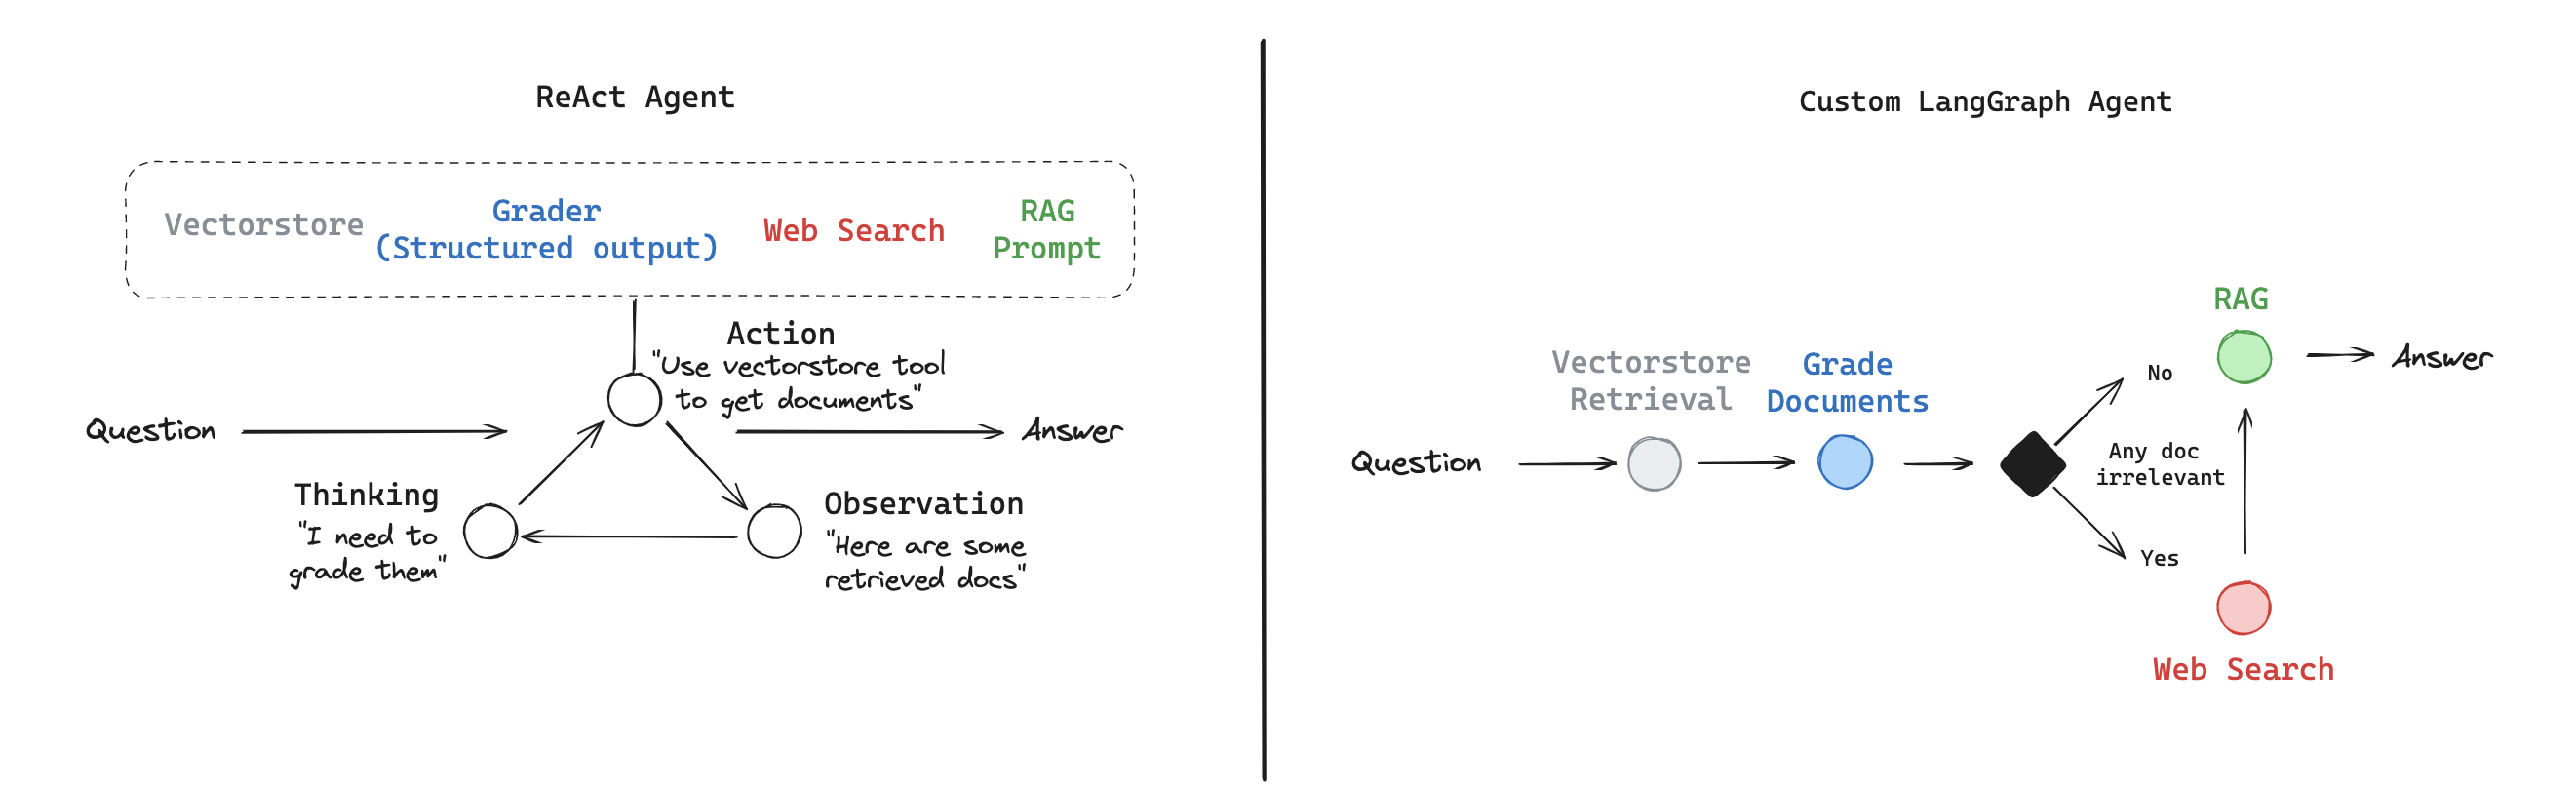

In [ ]:
%%capture --no-stderr
%pip install -U langchain tavily-python langgraph matplotlib langchain_community tiktoken langchain-openai chromadb

In [ ]:
import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

In [2]:
import os
os.environ["LANGCHAIN_PROJECT"] = "corrective-rag-agent-testing"

## LLM

Select the LLM to use.

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

## Tools

We'll define a few tools.

In [4]:
### Retriever

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools import tool

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever(k=4)

@tool
def retrieve_documents(query: str) -> list:
    """Retrieve from index."""
    return retriever.invoke(query)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [58]:
### Generate

from langchain.prompts import PromptTemplate
from langchain import hub
from langchain_core.messages import ToolMessage
from langchain_core.output_parsers import StrOutputParser
import uuid 

# Prompt
prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 
    
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"],
)

# Chain
rag_chain = prompt | llm | StrOutputParser()

@tool
def generate_answer(query: str) -> str:
    """Generate answer to the question using the retrieved documents."""
    # return  rag_chain.invoke({"documents": docs, "question": question})
    return ToolMessage(content="Use the retrieved documents to concisely answer the question using three sentences maximum.",
                       tool_call_id=str(uuid.uuid4()))

In [59]:
### Grade

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM with tool call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = '''You are a teacher grading a quiz. You will be given: 
1/ a QUESTION 
2/ a set of comma separated FACTS provided by the student

You are grading RELEVANCE RECALL:
A score of 1 means that ANY of the FACTS are relevant to the QUESTION. 
A score of 0 means that NONE of the FACTS are relevant to the QUESTION. 
1 is the highest (best) score. 0 is the lowest score you can give. 

Explain your reasoning in a step-by-step manner. Ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset.'''

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "FACTS: \n\n {documents} \n\n QUESTION: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

@tool
def grade_document_retrieval(query: str) -> str:
    """Grade documents relative to the question to confirm they are relevant."""
    # return  retrieval_grader.invoke({"documents": "\FACT\n".join(doc['page_content'] for doc in docs), "question": query})
    return ToolMessage(content=system,
                       tool_call_id=str(uuid.uuid4()))

In [60]:
### Search

from langchain.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults()

@tool
def web_search(query: str) -> str:
    """Run web search on the question."""
    web_results = web_search_tool.invoke({"query": query})
    return [Document(page_content=d['content'],metadata={'url':d['url']}) for d in web_results]

In [61]:
### Tools list

tools = [
    web_search,
    grade_document_retrieval,
    generate_answer,
    retrieve_documents
]

## ReAct Agent

#### Agent logic

In [67]:
from typing import Annotated, List
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

class Assistant:
    
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            # Invoke the tool-calling LLM
            result = self.runnable.invoke(state)
            # If it is a tool call -> response is valid
            # If it has meaninful text -> response is valid
            # Otherwise, we re-prompt it b/c response is not meaninful
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

# Prompt 
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            " You are a helpful assistant for with four tools: (1) retrieve_documents, "
            " (2) grade_document_retrieval, (3) web_search, (4) generate_answer."  
            " First, use the retrieve_documents tool to retrieve documents. Then, grade the documents based upon the grade make a"
            " decision to use web_search if they are not relevant to the question or directly invoke the generate_answer tool. "
            " Finally, use generate_answer to produce an answer to the question using the results from retrieval and / or web search. "
        ),
        ("placeholder", "{messages}"),
    ]
)

# LLM chain
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

#### Utils

In [68]:
def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

#### Graph

In [69]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

# Define edges: these determine how the control flow moves
builder.set_entry_point("assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition, 
    # "tools" calls one of our tools. END causes the graph to terminate (and respond to the user)
    {"tools": "tools", END: END},
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
memory = SqliteSaver.from_conn_string(":memory:")
react_graph = builder.compile(checkpointer=memory)

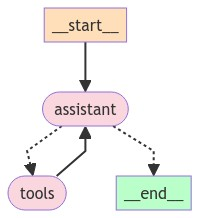

In [70]:
from IPython.display import Image, display

try:
    display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [ ]:
import uuid 
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

def predict_react_agent_answer(example: dict):
    """Use this for answer evaluation"""
    
    messages = react_graph.invoke({"messages": ("user", example["input"])}, config)
    return {"response": messages['messages'][-1].content, "messages":messages}

example = {"input":"What are the types of agent memory?"}
response = predict_react_agent_answer(example)       

## Custom LangGraph Agent

In [46]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps:List[str]

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {"documents": documents, "question": question, "generation": generation,"steps": steps}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No" 
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "documents": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "search": search, "steps": steps}

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend([Document(page_content=d['content'],metadata={'url':d['url']}) for d in web_results])
    return {"documents": documents, "question": question, "steps": steps}

### Edges

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"

from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

# Compile
custom_graph = workflow.compile()

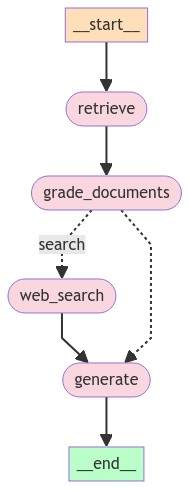

In [47]:
from IPython.display import Image, display

try:
    display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [48]:
def predict_custom_agent_answer(example:dict):
    state_dict = custom_graph.invoke({"question": example["input"], "steps": []}, config)
    return {"response": state_dict['generation'], "steps":state_dict['steps']}

example = {"input":"What are the types of agent memory?"}
response = predict_custom_agent_answer(example)       
response

{'response': 'The types of agent memory are short-term memory and long-term memory. Short-term memory involves in-context learning and temporarily holding information for immediate use. Long-term memory allows the agent to retain and recall information over extended periods, often using an external vector store for fast retrieval.',
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'web_search',
  'generate_answer']}

## Eval

### Response

https://docs.smith.langchain.com/tutorials/Developers/agents#response-evaluation

In [26]:
from langsmith import Client
client = Client()

# Create a dataset
examples = [
    ("How does the ReAct agent use self-reflection? ", 
     "ReAct integrates reasoning and acting, performing actions - such tools like Wikipedia search API - and then observing / reasoning about the tool outputs."),
    ("What are the types of biases that can arise with few-shot prompting?", 
     "The biases that can arise with few-shot prompting include (1) Majority label bias, (2) Recency bias, and (3) Common token bias."),
    ("What are five types of adversarial attacks?",
     "Five types of adversarial attacks are (1) Token manipulation, (2) Gradient based attack, (3) Jailbreak prompting, (4) Human red-teaming, (5) Model red-teaming."),
    ("Who did the Chicago Bears draft first in the 2024 NFL draft”?",
     "The Chicago Bears drafted Caleb Williams first in the 2024 NFL draft."),
    ("Who won the 2024 NBA finals?",
     "The Boston Celtics on the 2024 NBA finals"),
]

dataset_name = "Corrective RAG Agent Testing"
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    inputs, outputs = zip(
        *[({"input": text}, {"output": label}) for text, label in examples]
    )
    client.create_examples(inputs=inputs, outputs=outputs, dataset_id=dataset.id)

In [27]:
from langchain import hub
from langchain_openai import ChatOpenAI

# Grade prompt
grade_prompt_answer_accuracy = prompt = hub.pull("langchain-ai/rag-answer-vs-reference")

def answer_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy
    """

    # Get question, ground truth answer, RAG chain answer
    input_question = example.inputs["input"]
    reference = example.outputs["output"]
    prediction = run.outputs["response"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4-turbo", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_answer_accuracy | llm

    # Run evaluator
    score = answer_grader.invoke({"question": input_question,
                                  "correct_answer": reference,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_v_reference_score", "score": score}

### Trajectory

https://docs.smith.langchain.com/tutorials/Developers/agents#trajectory

In [30]:
from langsmith.schemas import Example, Run

expected_trajectory = ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']

def find_tool_calls_react(messages):
    """
    Find all tool calls in the messages returned
    """
    tool_calls = [tc['name'] for m in messages['messages'] for tc in getattr(m, 'tool_calls', [])]
    return tool_calls

def check_trajectory_react(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in exact order and without any additional tool calls.
    """
    
    messages = root_run.outputs["messages"]
    tool_calls = find_tool_calls(messages)
    print(f"Tool calls ReAct agent: {tool_calls}")
    if tool_calls == expected_trajectory:
        score = 1
    else:
        score = 0

    return {"score": int(score), "key": "tool_calls_in_exact_order"}

def check_trajectory_custom(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in exact order and without any additional tool calls.
    """
    
    tool_calls = root_run.outputs["steps"]
    print(f"Tool calls custom agent: {tool_calls}")
    if tool_calls == expected_trajectory:
        score = 1
    else:
        score = 0

    return {"score": int(score), "key": "tool_calls_in_exact_order"}

In [ ]:
import uuid 
config = {
    "configurable": {
        "thread_id": str(uuid.uuid4()),
    }
}

from langsmith.evaluation import evaluate
experiment_prefix="react-agent"
metadata = "CRAG, gpt-4o"
experiment_results = evaluate(
    predict_react_agent_answer,
    data=dataset_name,
    evaluators=[answer_evaluator,check_trajectory_react],
    experiment_prefix=experiment_prefix + "-response-v-reference",
    num_repetitions=1,
    metadata={"version": metadata},
)

import uuid 
config = {
    "configurable": {
        "thread_id": str(uuid.uuid4()),
    }
}

experiment_prefix="custom-agent"
metadata = "CRAG, gpt-4o"
experiment_results = evaluate(
    predict_custom_agent_answer,
    data=dataset_name,
    evaluators=[answer_evaluator,check_trajectory_custom],
    experiment_prefix=experiment_prefix + "-response-v-reference",
    num_repetitions=1,
    metadata={"version": metadata},
)